In [12]:
# imports
from load_data import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


In [1]:
# Load Data
fp = "/Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-cleaned.csv"

df = load_dataset(fp, type="pandas", sep=",")
print(df.columns)

load_dataset - Filepath: /Users/augusttollerup/Documents/SEM4/Fagprojekt/Data/agg-cleaned.csv
Loaded dataset to Pandas DataFrame
Index(['meter_id', 'type', 'timeslot', 'num_kwh', 'spot_price_no_vat',
       'amount_no_vat', 'amount_with_vat', 'vat_percent', 'ediel_product_code',
       'kwh_fee_no_vat'],
      dtype='object')


In [2]:
df_prod = df[df["type"] == "production"]
df_prod.reset_index(drop=True, inplace=True)

df_cons = df[df["type"] == "consumption"]
df_cons.reset_index(drop=True, inplace=True)

In [3]:
# Print unique timeslots
print("Timeslots in entire dataset: ",len(df["timeslot"]))
print("Timeslots in production: ",len(df_prod["timeslot"]))
print("Timeslots in consumption: ",len(df_cons["timeslot"]))

Timeslots in entire dataset:  17934937
Timeslots in production:  4568586
Timeslots in consumption:  9956353


In [4]:
# Get index for timeslot = 01-01-2018 00:01:00

def create_ideal_index(index_start, index_end):
    new_index = pd.date_range(start = index_start, end = index_end, freq = "1H")
    # Convert new_index to string
    new_index = [str(x).replace("02:00", "02") for x in new_index]
    return new_index


In [5]:
def plot_missing_dates_on_timeline(start, end, missing, title = "Missing timeslots"):
    """Plot missing dates on timeline

    Args:
        min (datetime): start date on timeline
        max (datetime): end date on timeline
        missing (list): list of missing dates in the interval
        title (str, optional): Plot title. Defaults to "Missing timeslots".
    """
    
    # Plot missing timeslot values 
    # Inspired by https://matplotlib.org/3.5.1/gallery/lines_bars_and_markers/timeline.html

    # Choose some nice levels
    levels = np.tile([-5, 5, -3, 3, -1, 1],
                    int(np.ceil(len(missing)/6)))[:len(missing)]

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)
    ax.set(title=title)

    ax.vlines(missing, 0, levels, color="tab:red")  # The vertical stems.
    ax.plot(missing, np.zeros_like(missing), "-o",
            color="k", markerfacecolor="w")  # Baseline and markers on it.

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    ax.spines[["left", "top", "right"]].set_visible(False)

    # Set x-axis interval
    ax.set_xlim(start, end)

    ax.margins(y=0.1)
    plt.show()

In [83]:
def plot_missing_timeslots(start, end, ideal, missing, title = "Missing timeslots"):
    first_timeslot = start
    last_timeslot = end

    # Set first and last element of ideal to x_labels
    x_labels = missing.copy()
    x_labels[0] = first_timeslot
    x_labels[-1] = last_timeslot

    # plot dot on horisontal line for ideal timeslots
    plt.rcParams["figure.figsize"] = (22,3)
    plt.plot(ideal, [0] * len(ideal), "-o", markerfacecolor="none", markeredgecolor="black", markersize=1)
    # Show only first and last x-axis label
    # Plot vertical line for missing timeslots with red dot
    plt.vlines(missing, 0, 1, color="red", linewidth=1, label="Missing", alpha=0.5, linestyle="--")
    # Rotate x-axis labels
    plt.xticks([first_timeslot] + missing + [last_timeslot], rotation=90)
    plt.legend()
    plt.title(title)
    plt.show()



In [6]:
# Get unique meter_ids
meter_ids_unique = df_prod.meter_id.unique()
print(len(meter_ids_unique))

542


In [28]:
# Fix timeslot
def fix_timeslot(timeslot):
    # Match +01 and +01:00
    re_match = r"(\+01:00|\+01)"
    
    # Convert from summer to winter time
    if re.findall(re_match, timeslot) != []:
        print("Found summer time for first timeslot: ", timeslot)
        # Convert to timestamp
        timeslot = pd.to_datetime(timeslot)
        # Convert from +01:00 to +02:00
        timeslot = timeslot - pd.Timedelta(hours=1)
        # Convert back to string
        timeslot = str(timeslot).replace("+01:00", "+02").replace("+01", "+02")
    
    return timeslot


In [99]:
# Loop through meter_ids and calculate yearly coverage
full_coverage_meter_ids = []

# Define dataset to use
df_loop = df_prod

df_coverages = pd.DataFrame(columns=["meter_id", "year_coverage"])

for idx, meter_id in enumerate(meter_ids_unique):
    dat = sorted(df_loop[df_loop["meter_id"] == meter_id]["timeslot"].values)

    # Get first and last timeslot
    first_timeslot = fix_timeslot(str(dat[0]))
    last_timeslot = fix_timeslot(str(dat[-1]))


    # print("First Timeslot: ", first_timeslot)
    # print("Last Timeslot: ", last_timeslot)

    new_index = create_ideal_index(first_timeslot, last_timeslot)

    # print(dat[0], dat[-1])
    # print(new_index[0], new_index[-1])

    overlap = list(set(dat) & set(new_index))
    missing = list(set(new_index) - set(dat))
    # Calculate union of new_index and dat
    union = list(set(new_index) | set(dat))
    
    # Calculate overlap percentage
 
    coverage = len(overlap) / len(union)
    print("Meter_id: ", meter_id, " Coverage: ", coverage, ", ", idx, " out of ", len(meter_ids_unique))
    df_coverages.loc[idx] = [meter_id, coverage]


Found summer time for first timeslot:  2016-11-09 00:00:00+01
Meter_id:  0148117f-53bb-48ca-ae71-1523f099fb81  Coverage:  0.325247037886948 ,  0  out of  542
Found summer time for first timeslot:  2016-11-09 00:00:00+01
Meter_id:  028b54e1-6594-4fca-ba0d-bfbb5f9a8b6f  Coverage:  0.3337777643101724 ,  1  out of  542
Meter_id:  05afdd22-3570-4e5b-b4d2-6719ac8af2ac  Coverage:  0.33950563367979736 ,  2  out of  542
Meter_id:  08ef7b1d-5f62-46df-92fe-167ebc2229d7  Coverage:  0.3757523645743766 ,  3  out of  542
Meter_id:  0afd188d-d511-46c5-99e6-1754b2c92091  Coverage:  0.43134296184522525 ,  4  out of  542
Meter_id:  0d54d233-15a2-4253-a38a-69f325dc3ee7  Coverage:  0.1529528535980149 ,  5  out of  542
Found summer time for first timeslot:  2017-02-13 00:00:00+01
Meter_id:  0fbb107a-9d54-42bf-b203-6cbb4f6fbc4f  Coverage:  0.38794773359630896 ,  6  out of  542
Meter_id:  130ddc31-15a9-4caf-b077-b9919b98b87a  Coverage:  0.15087084370052026 ,  7  out of  542
Meter_id:  13da9e23-eabe-4ecc-bf19-

In [100]:
df_coverages = df_coverages.sort_values(by="year_coverage", ascending=False)
print(df_coverages.head())

                                 meter_id  year_coverage
461  66021983-01c3-4728-a811-79901825d50c       0.920089
77   9914102c-3c52-48f3-a3ee-8c0ed3c914c5       0.920032
280  18215651-1d98-4908-9197-5455e737df5f       0.920025
322  17d28473-6a86-449a-a3bc-4bdbcc1d91d5       0.920000
535  ee1b1208-39c8-4051-b1a8-deb52524563a       0.920000


In [101]:
# Save to csv
df_coverages.to_csv("year_coverage_production.csv", index=False)

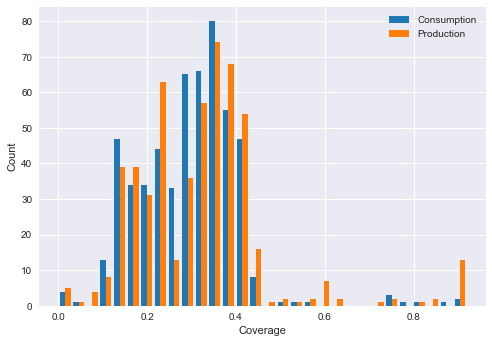

In [102]:
# Load csv
df_coverages_cons = pd.read_csv("year_coverage_consumption.csv")
df_coverages_prod = pd.read_csv("year_coverage_production.csv")
# Round to 1 decimal
df_coverages_cons["year_coverage"] = df_coverages_cons["year_coverage"].round(2)
df_coverages_prod["year_coverage"] = df_coverages_prod["year_coverage"].round(2)

# Plot  
# Set plot background color
plt.style.use('seaborn')
plt.hist([df_coverages_cons["year_coverage"],df_coverages_prod["year_coverage"]], bins=30, label=["Consumption", "Production"],
                    color=["tab:blue", "tab:orange"])
plt.ylabel("Count")
plt.xlabel("Coverage")
plt.legend(["Consumption", "Production"])
plt.show()


In [103]:
# Find 10 meter_ids with highest coverage
df_coverages_10_cons = df_coverages_cons.head(10)
df_coverages_10_prod = df_coverages_prod.head(10)

print(df_coverages_10_cons)
print(df_coverages_10_prod)

                               meter_id  year_coverage
0  66021983-01c3-4728-a811-79901825d50c           0.92
1  e804c3ee-1aaf-4deb-9475-8d676ac5eabc           0.92
2  531cc9ae-22a6-4b93-b6a9-649f907c6b0e           0.88
3  e1b0c487-90fb-4cb6-b996-7448d3a833d7           0.80
4  9914102c-3c52-48f3-a3ee-8c0ed3c914c5           0.78
5  f519028f-760c-4d29-9639-ad7e127fd52c           0.75
6  d926790e-7d17-4f85-9664-aaa04c877d95           0.74
7  cbd288c0-3836-4e9d-9437-2cf394cc3709           0.74
8  14338d78-9f43-4fa6-ba70-e719a4d45025           0.58
9  84b16f67-2964-4350-9782-2a7587fd6c55           0.54
                               meter_id  year_coverage
0  66021983-01c3-4728-a811-79901825d50c           0.92
1  9914102c-3c52-48f3-a3ee-8c0ed3c914c5           0.92
2  18215651-1d98-4908-9197-5455e737df5f           0.92
3  17d28473-6a86-449a-a3bc-4bdbcc1d91d5           0.92
4  ee1b1208-39c8-4051-b1a8-deb52524563a           0.92
5  20cb3962-7009-4c8e-bf70-ff3fa39d487c           0.92
6  34c581f

DET LIGNER DER ER NOGET GALT MED NEDENSTÅENDE PLOT!!!! COVERAGE ER SGU DA BLÆST UDREGNET

Coverage: 0    0.92
Name: year_coverage, dtype: float64


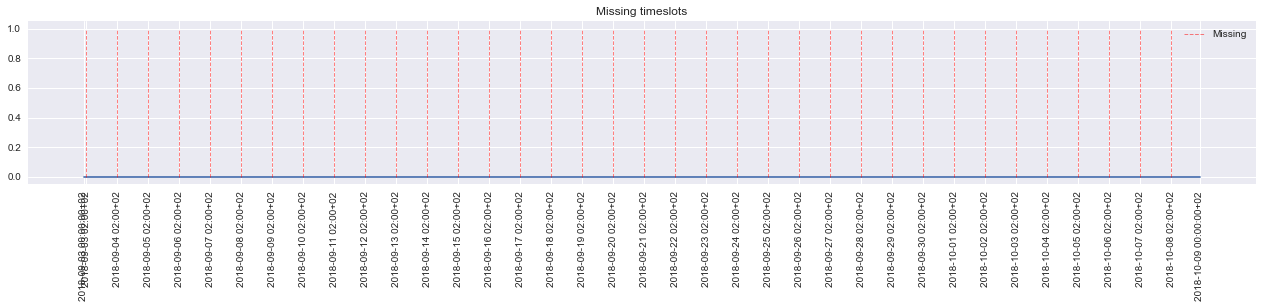

Coverage: 1    0.92
Name: year_coverage, dtype: float64


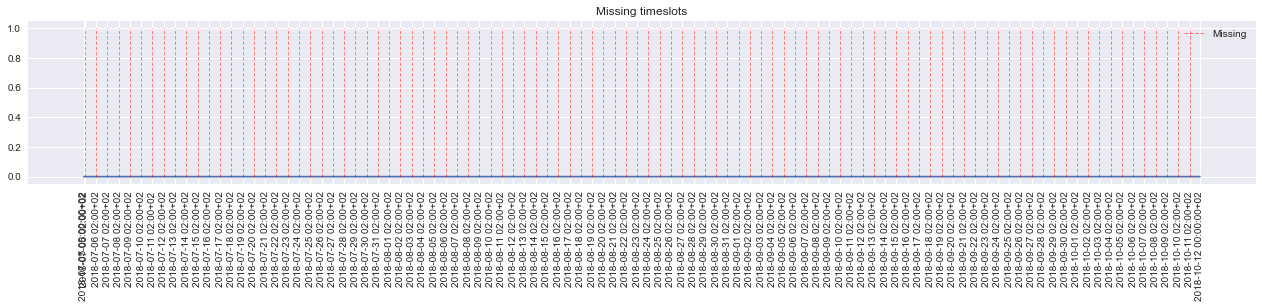

Coverage: 2    0.92
Name: year_coverage, dtype: float64


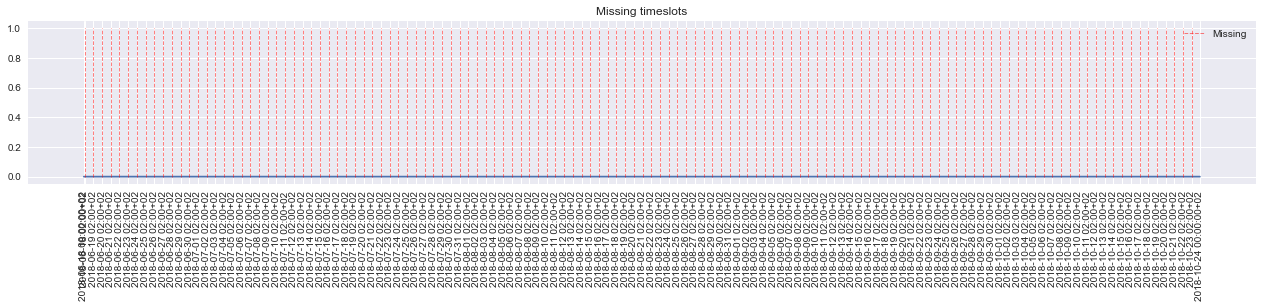

Coverage: 3    0.92
Name: year_coverage, dtype: float64


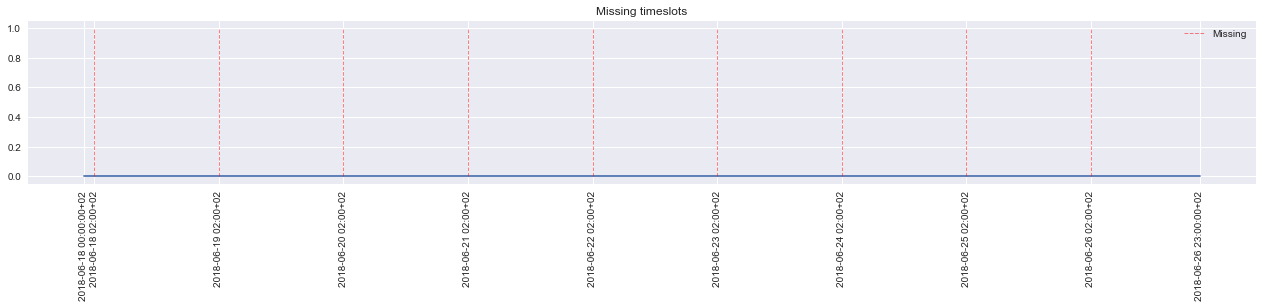

Coverage: 4    0.92
Name: year_coverage, dtype: float64


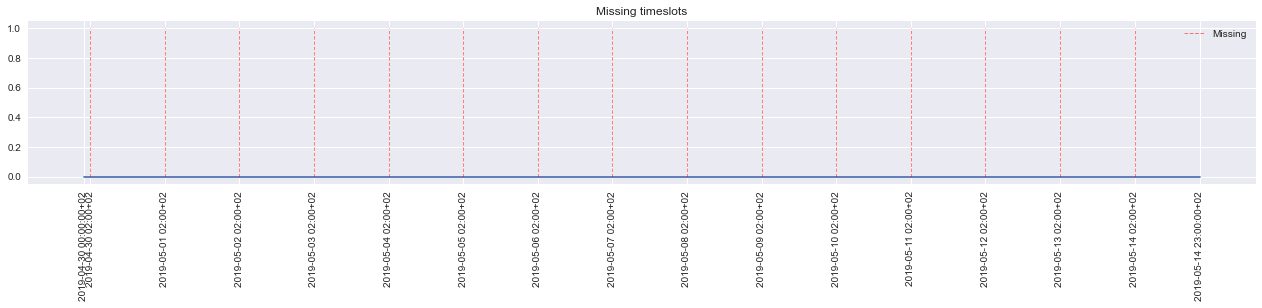

Coverage: 5    0.92
Name: year_coverage, dtype: float64


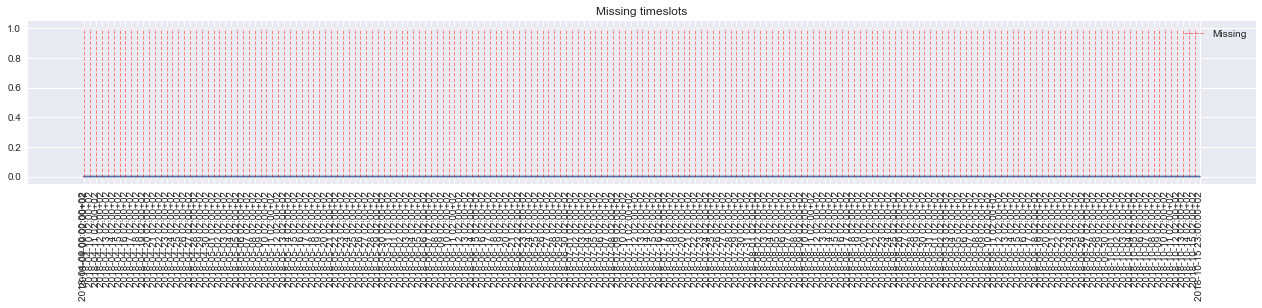

Coverage: 6    0.92
Name: year_coverage, dtype: float64


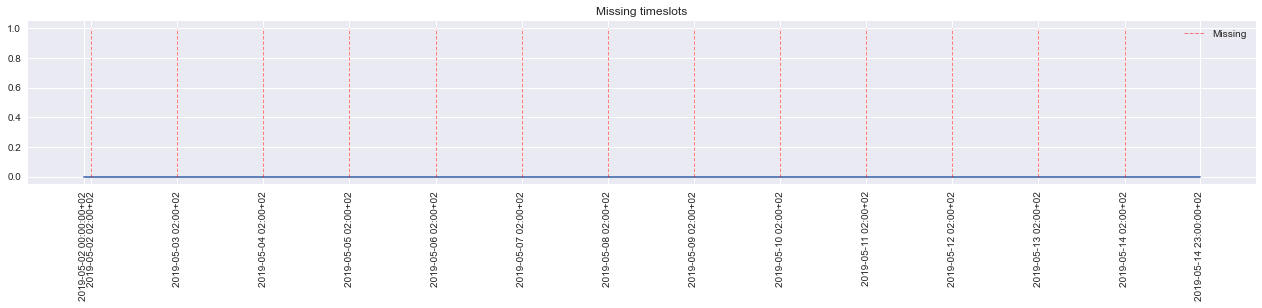

Coverage: 7    0.92
Name: year_coverage, dtype: float64


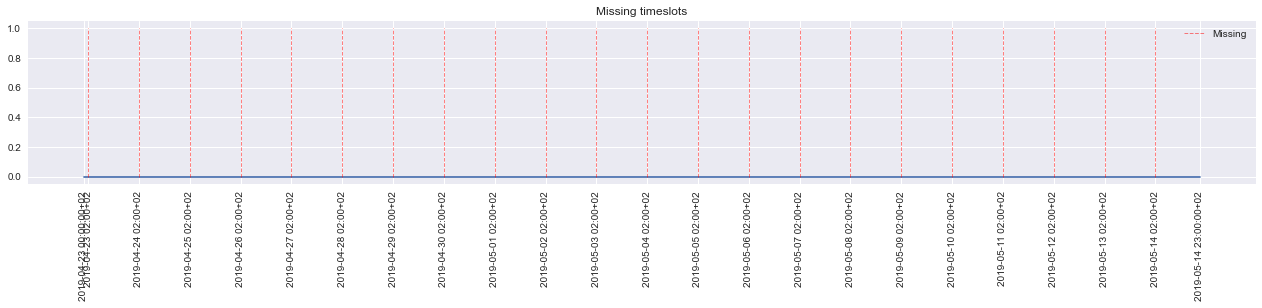

Coverage: 8    0.92
Name: year_coverage, dtype: float64


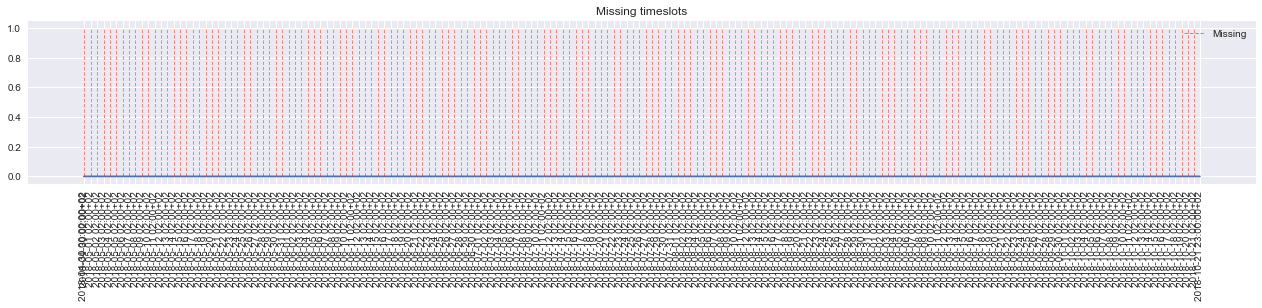

Coverage: 9    0.92
Name: year_coverage, dtype: float64


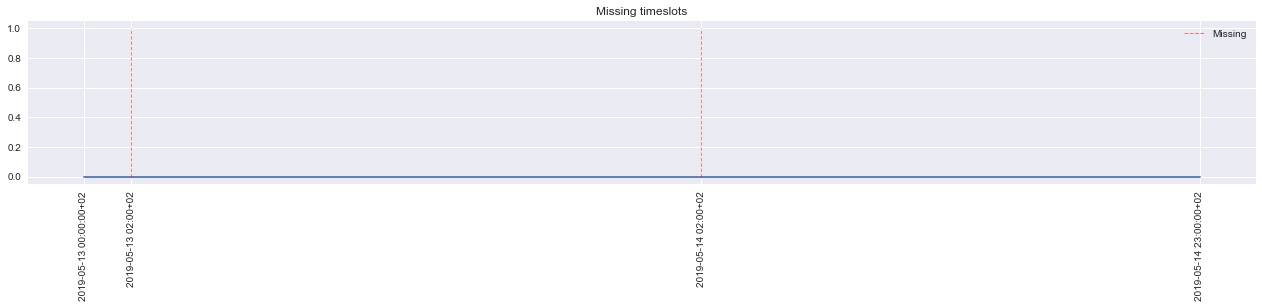

In [105]:
df_loop = df_prod
df_coverage_loop = df_coverages_10_prod
# Sort by coverage
df_coverage_loop = df_coverage_loop.sort_values(by="year_coverage", ascending=False)

for meter_id in df_coverage_loop["meter_id"]:

    dat = sorted(df_loop[df_loop["meter_id"] == meter_id]["timeslot"].values)
    first_timeslot = fix_timeslot(dat[0])
    last_timeslot = fix_timeslot(dat[-1])

    new_index = create_ideal_index(first_timeslot, last_timeslot)

    missing = list(set(new_index) - set(dat))
    # Sort missing timeslots
    missing = sorted(missing)
    # Sort ideal timeslots
    new_index = sorted(new_index)

    print("Coverage:", df_coverage_loop[df_coverage_loop["meter_id"] == meter_id]["year_coverage"])
    plot_missing_timeslots(first_timeslot, last_timeslot,
                            ideal=new_index, missing = missing)

In [153]:
# Now we want to interpolate the missing timeslots
# We for each missing timeslot, find the 2 closest timeslots and interpolate
# https://stackoverflow.com/questions/24216425/adding-a-new-pandas-column-with-mapped-value-from-a-dictionary
for meter_id in df_coverages_10["meter_id"]:
    print(meter_id)
    # For fanden altså, nu har vi jo et problem
    # Vi har ikke alle meter_ids i df_prod
    # Vi tjekker lige nu om meter_id er i df_prod
    # Hvis ikke, så skal vi ikke gøre noget
    if meter_id not in df_prod["meter_id"].unique():
        print("Meter_id not in df_prod")
        continue
    meter_dat = df_prod[df_prod["meter_id"] == meter_id]
    dat = sorted(meter_dat["timeslot"].values)
    print(meter_dat)
    first_timeslot = dat[0]
    last_timeslot = dat[-1]
    new_index = create_ideal_index(first_timeslot, last_timeslot)
    missing_timeslots = list(set(new_index) - set(dat))
    # Create dictionary for the missing timeslots
    # Add rows for the missing timeslots

    # ['meter_id', 'type', 'timeslot', 'num_kwh', 'spot_price_no_vat',
    #   'amount_no_vat', 'amount_with_vat', 'vat_percent', 'ediel_product_code',
    #   'kwh_fee_no_vat']

    for missing in missing_timeslots:
        meter_dat.iloc[-1] = [meter_id, "production", missing, None, None,
                                None, None, None, None, None]
    # Sort by timeslot
    meter_dat = meter_dat.sort_values(by="timeslot")
    print(meter_dat.head())
    break

    

    

b79ddbf7-7108-499b-a25f-bc221d6a0eb5
Meter_id not in df_prod
53ec96f2-eb13-4913-b68b-64ba60169aaa
Meter_id not in df_prod
6fc239a3-31e7-4dd9-8f2f-6d3ab67fdcd8
Meter_id not in df_prod
9c7cbe13-f6df-422e-9e0a-837055881eca
Meter_id not in df_prod
3ac9d676-e9a1-4604-a985-80249c12e067
Meter_id not in df_prod
64ce2f20-0109-41e8-a5a9-623083b460eb
Meter_id not in df_prod
6286b5cf-630c-4b7d-8838-7da2ec96c298
Meter_id not in df_prod
d263b9f6-4a46-43dd-b926-b0a4e6c6b8a3
Meter_id not in df_prod
8c05756c-9c23-4bf3-9fa7-7c02ba8570f4
Meter_id not in df_prod
70df225e-a04b-4d54-bf10-a85c4f4f78dc
Meter_id not in df_prod
